In [1]:
from molmap import model as molmodel
import molmap
from molmap import dataset
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from joblib import load, dump
tqdm.pandas(ascii=True)
import numpy as np

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

RDKit WARNING: [17:06:06] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
def get_attentiveFP_idx(df, file = './split_and_data/04_Malaria_attentiveFP.data'):
    """ attentiveFP dataset"""
    train, valid = load(file)
    test = valid
    
    # only train, valid
    
    print('training set: %s, valid set: %s, test set %s' % (len(train), len(valid), len(test)))
    train_idx = df[df.smiles.isin(train.smiles)].index
    valid_idx = df[df.smiles.isin(valid.smiles)].index
    test_idx = df[df.smiles.isin(test.smiles)].index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx 

In [3]:
mp1 = molmap.loadmap('../descriptor.mp')
mp2 = molmap.loadmap('../fingerprint.mp')

task_name = 'Malaria'

data = dataset.load_malaria()


total samples: 9999


In [4]:
df = data.data

In [5]:
train_idx, valid_idx, test_idx = get_attentiveFP_idx(df) #random seed has no effects
len(train_idx), len(valid_idx), len(test_idx)

training set: 7999, valid set: 2000, test set 2000
training set: 7999, valid set: 2000, test set 2000


(7999, 2000, 2000)

In [6]:
tmp_feature_dir = './tmpignore'
if not os.path.exists(tmp_feature_dir):
    os.makedirs(tmp_feature_dir)

smiles_col = df.columns[0]
values_col = df.columns[1:]
Y = df[values_col].astype('float').values
Y = Y.reshape(-1, 1)


X1_name = os.path.join(tmp_feature_dir, 'X1_%s.data' % task_name)
X2_name = os.path.join(tmp_feature_dir, 'X2_%s.data' % task_name)
if not os.path.exists(X1_name):
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, X1_name)
else:
    X1 = load(X1_name)

if not os.path.exists(X2_name): 
    X2 = mp2.batch_transform(df.smiles, n_jobs = 8)
    dump(X2, X2_name)
else:
    X2 = load(X2_name)

molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]

In [7]:
epochs = 800
patience = 50 #early stopping

dense_layers = [256, 128, 32]
batch_size = 128
lr = 1e-4
weight_decay = 0

loss = 'mse'
monitor = 'val_loss'
dense_avf = 'relu'
last_avf = 'linear'


In [8]:
print(len(train_idx), len(valid_idx), len(test_idx))

trainX = (X1[train_idx], X2[train_idx])
trainY = Y[train_idx]

validX = (X1[valid_idx], X2[valid_idx])
validY = Y[valid_idx]

testX = (X1[test_idx], X2[test_idx])
testY = Y[test_idx]            

7999 2000 2000


In [9]:
np.random.seed(77)
tf.compat.v1.set_random_seed(77)

model = molmodel.net.DoublePathNet(molmap1_size, molmap2_size, 
                                   n_outputs=Y.shape[-1], 
                                   dense_layers=dense_layers, 
                                   dense_avf = dense_avf, 
                                   last_avf=last_avf)

opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
#import tensorflow_addons as tfa
#opt = tfa.optimizers.AdamW(weight_decay = 0.1,learning_rate=0.001,beta1=0.9,beta2=0.999, epsilon=1e-08)
model.compile(optimizer = opt, loss = loss)
performance = molmodel.cbks.Reg_EarlyStoppingAndPerformance((trainX, trainY), 
                                                           (validX, validY), 
                                                           patience = patience, 
                                                           criteria = monitor)
model.fit(trainX, trainY, batch_size=batch_size, 
      epochs=epochs, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performance]) 


best_epoch = performance.best_epoch
trainable_params = model.count_params()

train_rmses, train_r2s = performance.evaluate(trainX, trainY)            
valid_rmses, valid_r2s = performance.evaluate(validX, validY)            
test_rmses, test_r2s = performance.evaluate(testX, testY)


final_res = {
             'task_name':task_name,            
             'train_rmse':np.nanmean(train_rmses), 
             'valid_rmse':np.nanmean(valid_rmses),                      
             'test_rmse':np.nanmean(test_rmses), 

             'train_r2':np.nanmean(train_r2s), 
             'valid_r2':np.nanmean(valid_r2s),                      
             'test_r2':np.nanmean(test_r2s), 

             '# trainable params': trainable_params,
             'best_epoch': best_epoch,
             'batch_size':batch_size,
             'lr': lr,
             'weight_decay':weight_decay
            }

epoch: 0001, loss: 1.4488 - val_loss: 1.4894; rmse: 1.1883 - rmse_val: 1.2204;  r2: 0.0958 - r2_val: 0.1011                                                                                                    
epoch: 0002, loss: 1.3676 - val_loss: 1.3819; rmse: 1.1449 - rmse_val: 1.1755;  r2: 0.1340 - r2_val: 0.1414                                                                                                    
epoch: 0003, loss: 1.2681 - val_loss: 1.2623; rmse: 1.0960 - rmse_val: 1.1235;  r2: 0.2168 - r2_val: 0.2235                                                                                                    
epoch: 0004, loss: 1.1962 - val_loss: 1.1879; rmse: 1.0615 - rmse_val: 1.0899;  r2: 0.2496 - r2_val: 0.2481                                                                                                    
epoch: 0005, loss: 1.1333 - val_loss: 1.1647; rmse: 1.0421 - rmse_val: 1.0792;  r2: 0.2739 - r2_val: 0.2605                                                             

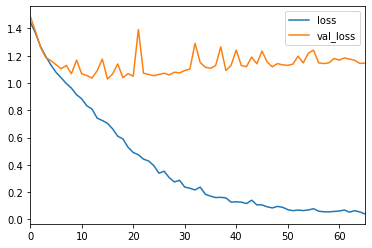

In [10]:
dfp = pd.DataFrame(performance.history)[['loss', 'val_loss']]
dfp.plot()

In [11]:
performance.evaluate(trainX, trainY)

([0.7793529139521367], [0.6019533197410153])

In [12]:
performance.evaluate(validX, validY)

([1.014532645969422], [0.3382343546134524])

In [13]:
performance.evaluate(testX, testY)

([1.014532645969422], [0.3382343546134524])